In [8]:
# 3D Mesh Reconstruction from Multiple Images - Mac Setup

## 0. Install Dependencies
# If you haven't already, you may need to install these in your terminal:
# conda install -c conda-forge libjpeg
# pip install opencv-python-headless

## 1. Imports and Setup
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Image handling
import cv2
from PIL import Image

# PyTorch specific imports
import torchvision.transforms as transforms

# PyTorch3D imports
import pytorch3d
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesVertex
)

# Determine best available device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Mac GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU - computations will be slow")

# Set random seed for reproducibility
torch.manual_seed(42)

# Optional: Check PyTorch version and capabilities
print(f"PyTorch version: {torch.__version__}")
print(f"Device in use: {device}")

# Verify PyTorch3D import
try:
    import pytorch3d
    print(f"PyTorch3D version: {pytorch3d.__version__}")
except ImportError:
    print("PyTorch3D is not installed. Please install it.")

# Image loading and preprocessing utility function
def load_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess an image
    
    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output size (width, height)
    
    Returns:
        torch.Tensor: Preprocessed image tensor
    """
    # Use OpenCV for more robust image loading
    img = cv2.imread(image_path)
    
    # Check if image is loaded successfully
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    
    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0
    
    # Convert to tensor
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).to(device)
    
    return img_tensor

# Example usage:
# image_tensor = load_image('path/to/your/image.jpg')

Using Mac GPU (MPS)
PyTorch version: 2.5.1
Device in use: mps
PyTorch3D version: 0.7.8


Dataset Information:
------------------------------
Total number of images found: 301

Image files:
  - DSC02728.jpg
  - DSC02714.jpg
  - DSC02700.jpg
  - DSC02933.jpg
  - DSC02927.jpg
  - DSC02884.jpg
  - DSC02890.jpg
  - DSC02847.jpg
  - DSC02853.jpg
  - DSC02852.jpg
  - DSC02846.jpg
  - DSC02891.jpg
  - DSC02885.jpg
  - DSC02926.jpg
  - DSC02932.jpg
  - DSC02701.jpg
  - DSC02715.jpg
  - DSC02729.jpg
  - DSC02703.jpg
  - DSC02717.jpg
  - DSC02924.jpg
  - DSC02930.jpg
  - DSC02918.jpg
  - DSC02893.jpg
  - DSC02887.jpg
  - DSC02850.jpg
  - DSC02688.jpg
  - DSC02844.jpg
  - DSC02878.jpg
  - DSC02879.jpg
  - DSC02845.jpg
  - DSC02689.jpg
  - DSC02851.jpg
  - DSC02886.jpg
  - DSC02892.jpg
  - DSC02919.jpg
  - DSC02931.jpg
  - DSC02925.jpg
  - DSC02716.jpg
  - DSC02702.jpg
  - DSC02706.jpg
  - DSC02712.jpg
  - DSC02909.jpg
  - DSC02921.jpg
  - DSC02935.jpg
  - DSC02896.jpg
  - DSC02882.jpg
  - DSC02869.jpg
  - DSC02855.jpg
  - DSC02841.jpg
  - DSC02699.jpg
  - DSC02698.jpg
  - DSC02840.jpg

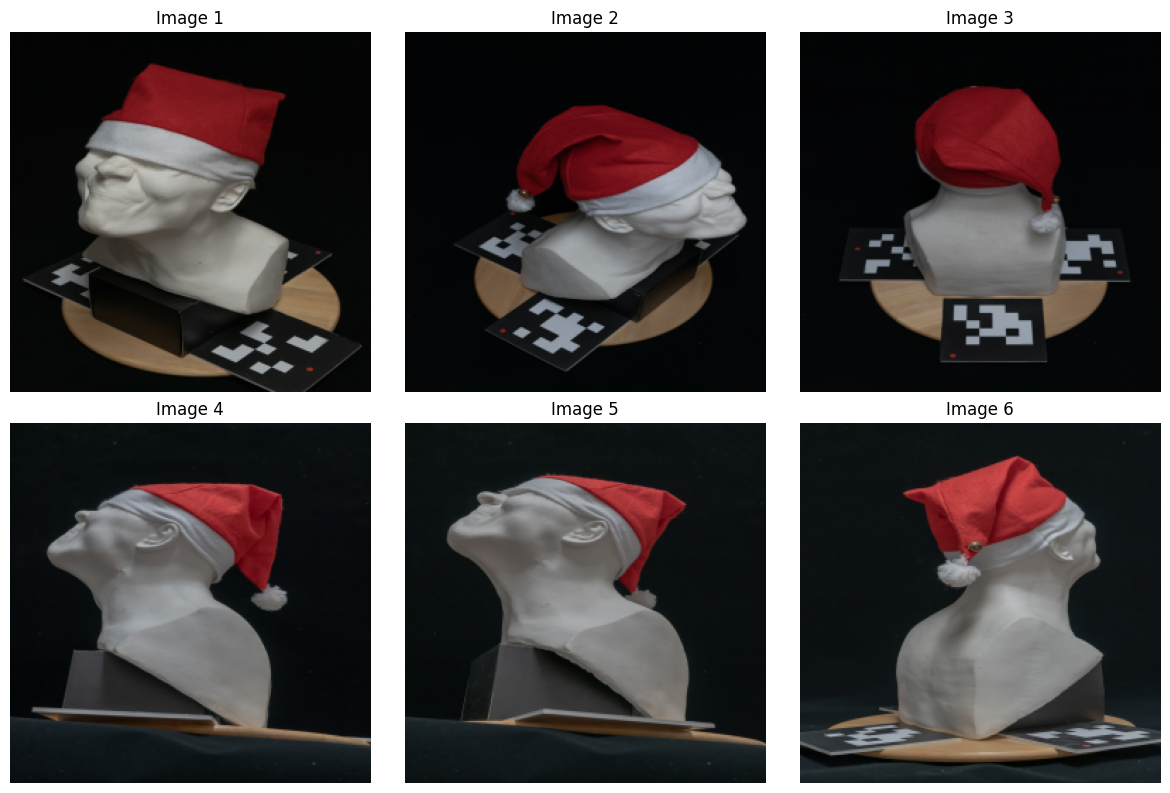

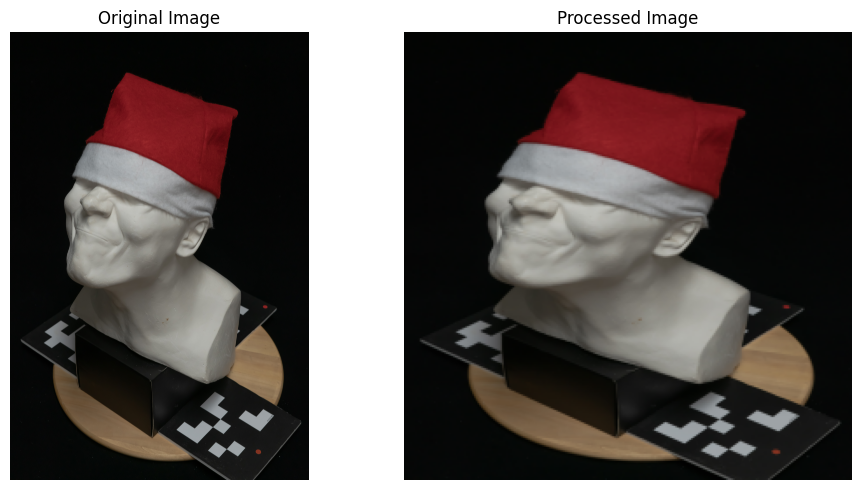


Dataset Metadata:
  - Path: media/DSC02728.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02714.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02700.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02933.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02927.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02884.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02890.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02847.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02853.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02852.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  - Path: media/DSC02846.jpg
    Original Size: (7952, 5304)
    Target Size: (256, 256)
  

In [10]:
# Load and Explore Image Dataset

# First, check the contents of the media folder
import os
import glob

# Path to the media folder
MEDIA_PATH = 'media'

# List all image files
image_files = []
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.tiff', '*.bmp', '*.gif']

for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(MEDIA_PATH, ext)))

# Print out dataset information
print("Dataset Information:")
print("-" * 30)
print(f"Total number of images found: {len(image_files)}")
print("\nImage files:")
for img in image_files:
    print(f"  - {os.path.basename(img)}")

# Prepare the dataset
dataset = ImageDataset(image_files)
processed_images = dataset.load_and_preprocess_images()

# Visualize the images
dataset.visualize_images()

# Optional: Compare an original image with its processed version
if image_files:
    compare_original_and_processed(image_files[0])

# Additional dataset exploration
print("\nDataset Metadata:")
for meta in dataset.metadata:
    print(f"  - Path: {meta['path']}")
    print(f"    Original Size: {meta['original_size']}")
    print(f"    Target Size: {meta['target_size']}")

/Users/jorgemuyo/miniforge3/envs/newenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jorgemuyo/miniforge3/envs/newenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/jorgemuyo/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|███████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 51.7MB/s]


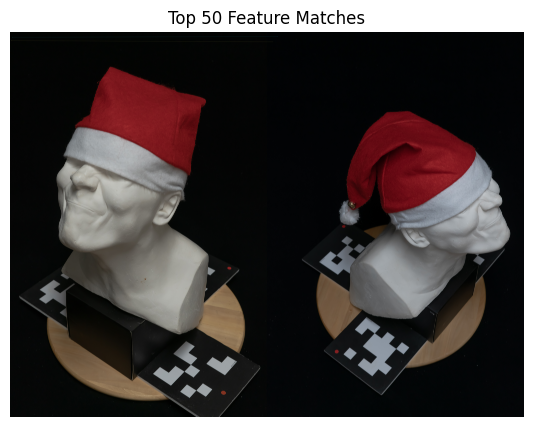

Extracted features for 301 images


In [13]:
# Feature Extraction Module (OpenCV-based)

import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models

class FeatureExtractor:
    def __init__(self, device=device):
        """
        Multi-method feature extraction for 3D reconstruction
        
        Combines:
        - Local feature descriptors (SIFT)
        - Global image features (ResNet)
        - Keypoint matching
        """
        self.device = device
        
        # Initialize feature detectors
        self._init_local_feature_detectors()
        self._init_global_feature_extractor()
    
    def _init_local_feature_detectors(self):
        """
        Initialize local feature detection methods
        """
        # Create SIFT detector
        self.sift = cv2.SIFT_create()
        
        # ORB as a backup/alternative
        self.orb = cv2.ORB_create()
    
    def _init_global_feature_extractor(self):
        """
        Initialize global feature extraction using ResNet
        """
        # Use ResNet50 pre-trained on ImageNet
        resnet = models.resnet50(pretrained=True)
        self.global_feature_extractor = nn.Sequential(
            *list(resnet.children())[:-1],  # Remove last fully connected layer
            nn.AdaptiveAvgPool2d(1)
        ).to(self.device).eval()
    
    def extract_local_features(self, image_tensor):
        """
        Extract local features (keypoints and descriptors)
        
        Args:
            image_tensor (torch.Tensor): Input image tensor
        
        Returns:
            dict: Keypoints and descriptors
        """
        # Convert tensor to numpy grayscale image
        if image_tensor.shape[0] == 3:
            gray_image = (image_tensor.mean(dim=0) * 255).byte().cpu().numpy()
        else:
            gray_image = (image_tensor.squeeze() * 255).byte().cpu().numpy()
        
        # Detect SIFT keypoints and descriptors
        kp_sift, des_sift = self.sift.detectAndCompute(gray_image, None)
        
        # Convert keypoints to torch tensor
        kp_locations = torch.tensor([kp.pt for kp in kp_sift]).to(self.device)
        des_tensor = torch.from_numpy(des_sift).to(self.device)
        
        return {
            'keypoints': kp_locations,
            'descriptors': des_tensor,
            'cv_keypoints': kp_sift
        }
    
    def extract_global_features(self, image_tensor):
        """
        Extract global image features using ResNet
        
        Args:
            image_tensor (torch.Tensor): Input image tensor
        
        Returns:
            torch.Tensor: Global image features
        """
        with torch.no_grad():
            # Ensure 4D tensor (batch, channels, height, width)
            if image_tensor.dim() == 3:
                image_tensor = image_tensor.unsqueeze(0)
            
            # Extract global features
            global_features = self.global_feature_extractor(image_tensor)
            return global_features.squeeze()
    
    def match_features(self, features1, features2):
        """
        Match features between two images
        
        Args:
            features1 (dict): Features from first image
            features2 (dict): Features from second image
        
        Returns:
            dict: Matched feature information
        """
        # Convert descriptors to numpy for OpenCV
        desc1 = features1['descriptors'].cpu().numpy()
        desc2 = features2['descriptors'].cpu().numpy()
        
        # Use FLANN matcher for feature matching
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(desc1, desc2, k=2)
        
        # Apply Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)
        
        return {
            'matches': good_matches,
            'keypoints1': features1['keypoints'],
            'keypoints2': features2['keypoints'],
            'cv_keypoints1': features1['cv_keypoints'],
            'cv_keypoints2': features2['cv_keypoints']
        }
    
    def extract_all_features(self, images):
        """
        Extract features for all images in the dataset
        
        Args:
            images (list): List of image tensors
        
        Returns:
            dict: Features for all images
        """
        all_features = {
            'local_features': [],
            'global_features': []
        }
        
        for img in images:
            # Extract local features
            local_feat = self.extract_local_features(img)
            all_features['local_features'].append(local_feat)
            
            # Extract global features
            global_feat = self.extract_global_features(img)
            all_features['global_features'].append(global_feat)
        
        return all_features

# Visualization of feature matching
def visualize_feature_matches(img1, img2, matches, top_n=50):
    """
    Visualize feature matches between two images
    
    Args:
        img1 (np.ndarray): First image
        img2 (np.ndarray): Second image
        matches (dict): Matched features
        top_n (int): Number of top matches to display
    """
    # Draw matches
    matched_img = cv2.drawMatches(
        img1, 
        matches['cv_keypoints1'],
        img2, 
        matches['cv_keypoints2'],
        matches['matches'][:top_n],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(15, 5))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Top {top_n} Feature Matches')
    plt.axis('off')
    plt.show()

# Initialize feature extractor
feature_extractor = FeatureExtractor()

# Extract features from the dataset
dataset_features = feature_extractor.extract_all_features(processed_images)

# Optional: Visualize matches between first two images
if len(processed_images) > 1:
    # Load original images for visualization
    img1_orig = cv2.imread(image_files[0])
    img2_orig = cv2.imread(image_files[1])
    
    # Extract and match features
    features1 = feature_extractor.extract_local_features(processed_images[0])
    features2 = feature_extractor.extract_local_features(processed_images[1])
    matches = feature_extractor.match_features(features1, features2)
    
    # Visualize matches
    visualize_feature_matches(img1_orig, img2_orig, matches)

print(f"Extracted features for {len(processed_images)} images")

In [18]:
# Comprehensive Camera Pose Estimation

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

class RobustKeypointExtractor:
    @staticmethod
    def extract_keypoints(image_tensor, max_keypoints=1000):
        """
        Extract keypoints using multiple methods
        
        Args:
            image_tensor (torch.Tensor): Input image tensor
            max_keypoints (int): Maximum number of keypoints to extract
        
        Returns:
            tuple: Keypoints and descriptors
        """
        # Convert tensor to numpy grayscale
        if image_tensor.dim() == 3 and image_tensor.shape[0] == 3:
            gray_image = (image_tensor.mean(dim=0) * 255).byte().cpu().numpy()
        elif image_tensor.dim() == 2:
            gray_image = (image_tensor * 255).byte().cpu().numpy()
        else:
            gray_image = (image_tensor.squeeze() * 255).byte().cpu().numpy()
        
        # Ensure image is 2D
        if len(gray_image.shape) > 2:
            gray_image = gray_image.squeeze()
        
        # Feature detectors with standardized descriptor length
        feature_detectors = [
            (cv2.SIFT_create(nfeatures=max_keypoints), 'sift'),
            (cv2.ORB_create(nfeatures=max_keypoints), 'orb'),
            (cv2.KAZE_create(), 'kaze')
        ]
        
        # Collect keypoints and descriptors
        all_results = []
        
        for detector, name in feature_detectors:
            try:
                # Detect keypoints and compute descriptors
                kp, des = detector.detectAndCompute(gray_image, None)
                
                if kp is not None and len(kp) > 0 and des is not None:
                    # Convert keypoints to numpy array of (x, y) coordinates
                    kp_coords = np.float32([list(point.pt) for point in kp])
                    
                    all_results.append({
                        'keypoints': kp_coords,
                        'descriptors': des,
                        'type': name
                    })
            except Exception as e:
                print(f"Error with {name} detector: {e}")
        
        # If no keypoints found
        if not all_results:
            return None, None
        
        # Select the result with most keypoints
        best_result = max(all_results, key=lambda x: len(x['keypoints']))
        
        return best_result['keypoints'], best_result['descriptors']

    @staticmethod
    def match_features(kp1, des1, kp2, des2, max_matches=50):
        """
        Robust feature matching
        
        Args:
            kp1 (np.ndarray): Keypoints from first image
            des1 (np.ndarray): Descriptors from first image
            kp2 (np.ndarray): Keypoints from second image
            des2 (np.ndarray): Descriptors from second image
            max_matches (int): Maximum number of matches to return
        
        Returns:
            dict: Matched feature information
        """
        if des1 is None or des2 is None:
            return None
        
        # Multiple matching strategies
        matchers = [
            cv2.BFMatcher(cv2.NORM_L2, crossCheck=True),  # Brute Force
            cv2.FlannBasedMatcher()  # FLANN
        ]
        
        all_matches = []
        for matcher in matchers:
            try:
                # K-nearest neighbors matching
                matches = matcher.knnMatch(des1, des2, k=2)
                
                # Lowe's ratio test
                good_matches = []
                for m, n in matches:
                    if m.distance < 0.7 * n.distance:
                        good_matches.append(m)
                
                all_matches.extend(good_matches)
            except Exception as e:
                print(f"Matching error: {e}")
        
        # If no matches found
        if not all_matches:
            return None
        
        # Limit matches
        all_matches = all_matches[:max_matches]
        
        # Extract matched points
        matched_pts1 = np.float32([kp1[m.queryIdx] for m in all_matches])
        matched_pts2 = np.float32([kp2[m.trainIdx] for m in all_matches])
        
        return {
            'matches': all_matches,
            'matched_pts1': matched_pts1,
            'matched_pts2': matched_pts2
        }

class RobustCameraPoseEstimator:
    def __init__(self, feature_extractor, processed_images, image_files):
        """
        Initialize Camera Pose Estimator
        
        Args:
            feature_extractor (FeatureExtractor): Feature extraction object
            processed_images (list): List of processed image tensors
            image_files (list): List of original image file paths
        """
        self.feature_extractor = feature_extractor
        self.processed_images = processed_images
        self.image_files = image_files
        self.keypoint_extractor = RobustKeypointExtractor()
    
    def extract_keypoints_and_descriptors(self, image_tensor):
        """
        Wrapper for keypoint extraction
        
        Args:
            image_tensor (torch.Tensor): Input image tensor
        
        Returns:
            tuple: Keypoints and descriptors
        """
        return self.keypoint_extractor.extract_keypoints(image_tensor)
    
    def estimate_fundamental_matrix(self, img1, img2):
        """
        Estimate fundamental matrix with robust matching
        
        Args:
            img1 (torch.Tensor): First image tensor
            img2 (torch.Tensor): Second image tensor
        
        Returns:
            dict: Fundamental matrix and match information
        """
        # Extract keypoints and descriptors
        kp1, des1 = self.extract_keypoints_and_descriptors(img1)
        kp2, des2 = self.extract_keypoints_and_descriptors(img2)
        
        # Validate keypoints
        if kp1 is None or kp2 is None:
            print("Failed to extract keypoints")
            return None
        
        # Match features
        matches = self.keypoint_extractor.match_features(kp1, des1, kp2, des2)
        
        # Validate matches
        if matches is None or len(matches['matches']) < 8:
            print(f"Insufficient matches: {len(matches['matches']) if matches else 0}")
            return None
        
        # Estimate fundamental matrix
        try:
            F, mask = cv2.findFundamentalMat(
                matches['matched_pts1'], 
                matches['matched_pts2'], 
                cv2.FM_RANSAC, 
                ransacReprojThreshold=3.0
            )
            
            # Filter matches
            inlier_mask = mask.ravel() == 1
            filtered_matches = [m for m, good in zip(matches['matches'], inlier_mask) if good]
            
            return {
                'fundamental_matrix': F,
                'matches': filtered_matches,
                'matched_pts1': matches['matched_pts1'][inlier_mask],
                'matched_pts2': matches['matched_pts2'][inlier_mask]
            }
        except Exception as e:
            print(f"Fundamental matrix estimation error: {e}")
            return None
    
    def estimate_camera_poses(self, max_pairs=50):
        """
        Estimate camera poses for multiple image pairs
        
        Args:
            max_pairs (int): Maximum number of image pairs to process
        
        Returns:
            list: Camera pose information for image pairs
        """
        camera_poses = []
        
        # Sample pairs of images
        num_images = len(self.processed_images)
        for i in range(min(max_pairs, num_images - 1)):
            img1 = self.processed_images[i]
            img2 = self.processed_images[i+1]
            
            # Estimate fundamental matrix
            fundamental_info = self.estimate_fundamental_matrix(img1, img2)
            
            if fundamental_info is None:
                continue
            
            # Estimate camera intrinsics (placeholder)
            h, w = img1.shape[1:]
            camera_matrix = np.array([
                [h, 0, w/2],
                [0, h, h/2],
                [0, 0, 1]
            ])
            
            try:
                # Estimate essential matrix
                E, _ = cv2.findEssentialMat(
                    fundamental_info['matched_pts1'], 
                    fundamental_info['matched_pts2'], 
                    camera_matrix
                )
                
                # Recover pose
                _, R, t, _ = cv2.recoverPose(
                    E, 
                    fundamental_info['matched_pts1'], 
                    fundamental_info['matched_pts2']
                )
                
                camera_poses.append({
                    'image_pair': (i, i+1),
                    'image_files': (self.image_files[i], self.image_files[i+1]),
                    'fundamental_matrix': fundamental_info['fundamental_matrix'],
                    'essential_matrix': E,
                    'rotation': R,
                    'translation': t,
                    'matches': fundamental_info['matches'],
                    'matched_pts1': fundamental_info['matched_pts1'],
                    'matched_pts2': fundamental_info['matched_pts2']
                })
            except Exception as e:
                print(f"Error processing image pair {i}, {i+1}: {e}")
        
        return camera_poses

# Visualization functions
def visualize_camera_poses(camera_poses):
    """
    Visualize estimated camera poses
    
    Args:
        camera_poses (list): List of camera pose estimations
    """
    plt.figure(figsize=(15, 5 * min(5, len(camera_poses))))
    
    for i, pose in enumerate(camera_poses[:5]):  # Limit to first 5 pairs
        plt.subplot(min(5, len(camera_poses)), 1, i+1)
        plt.title(f"Camera Pair {pose['image_pair']}")
        
        # Visualize rotation matrix
        plt.imshow(pose['rotation'], cmap='coolwarm')
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()

def visualize_pose_matches(camera_poses):
    """
    Visualize feature matches for estimated camera poses
    
    Args:
        camera_poses (list): List of camera pose estimations
    """
    for pose in camera_poses[:3]:  # Visualize first 3 pairs
        try:
            img1 = cv2.imread(pose['image_files'][0])
            img2 = cv2.imread(pose['image_files'][1])
            
            # Create keypoints from matched points
            kp1 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pose['matched_pts1']]
            kp2 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pose['matched_pts2']]
            
            # Draw matches
            matched_img = cv2.drawMatches(
                img1, kp1,
                img2, kp2,
                pose['matches'][:50],  # Limit to first 50 matches
                None,
                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
            )
            
            plt.figure(figsize=(15, 5))
            plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Feature Matches for Pair {pose['image_pair']}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error visualizing pose matches: {e}")

# Initialize camera pose estimator
camera_pose_estimator = RobustCameraPoseEstimator(
    feature_extractor, 
    processed_images, 
    image_files
)

# Estimate camera poses
camera_poses = camera_pose_estimator.estimate_camera_poses()

# Visualize camera poses
visualize_camera_poses(camera_poses)

# Visualize feature matches
visualize_pose_matches(camera_poses)

print(f"Estimated camera poses for {len(camera_poses)} image pairs")

Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/batch_distance.cpp:303: error: (-215:Assertion failed) K == 1 && update == 0 && mask.empty() in function 'batchDistance'

Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/flann/src/miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=0
> 
Insufficient matches: 0
Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/batch_distance.cpp:303: error: (-215:Assertion failed) K == 1 && update == 0 && mask.empty() in function 'batchDistance'

Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/flann/src/miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=0
>

Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/batch_distance.cpp:303: error: (-215:Assertion failed) K == 1 && update == 0 && mask.empty() in function 'batchDistance'

Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/flann/src/miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=0
> 
Insufficient matches: 0
Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/batch_distance.cpp:303: error: (-215:Assertion failed) K == 1 && update == 0 && mask.empty() in function 'batchDistance'

Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/flann/src/miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=0
>

Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/batch_distance.cpp:303: error: (-215:Assertion failed) K == 1 && update == 0 && mask.empty() in function 'batchDistance'

Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/flann/src/miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=0
> 
Insufficient matches: 0
Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/batch_distance.cpp:303: error: (-215:Assertion failed) K == 1 && update == 0 && mask.empty() in function 'batchDistance'

Matching error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/flann/src/miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=0
>

<Figure size 1500x0 with 0 Axes>

Estimated camera poses for 0 image pairs


Mesh saved successfully!
